In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import ase
from ase.build import fcc111
from ase.visualize.plot import plot_atoms

import torch
torch.set_default_dtype(torch.float64)

## From classical to neural potentials

This document introduces graph neural network models for atomistic properties by building up from classical interatomic potentials
Interatomic potentials model the energy of a system of atoms as a function of the atomic species and coordinates.

See https://arxiv.org/abs/2204.09563 for a comprehensive overview.


Classical potentials expand the total energy $U(\{\mathbf{r}\})$ into additive contributions for pairs, triplets, and higher order cliques of atoms:

$$
U(\{\mathbf{r}\}) = \sum_i \phi_1(\mathbf{r}_i)  
+ \sum_i \sum_j \phi_2(\mathbf{r}_i, \mathbf{r}_j) 
+ \sum_i \sum_j \sum_k \phi_3(\mathbf{r}_i, \mathbf{r}_j, \mathbf{r}_k)
+ \ldots
$$

where $\{\mathbf{r}\}$ is the set of all atomic coordinates $\mathbf{r}_i$, and $\phi_1$, $\phi_2$, $\phi_3$, etc are unary, pair, and triplet interaction functions. (In general, these functions are also species-dependent, but we'll ignore that to keep the notation simple.)

In classical interatomic potentials, the functions $\phi$ are generally based on a physically-motivated functional form, while in machine learning (ML) potentials they are implemented by neural networks, Gaussian processes, or similar.

Let's start with a simple pair potential and build up our understanding!

## Lennard Jones pair potential
Consider a simple unary system: a 2D hexagonal lattice of Ne atoms.
Noble gases like this are often modeled with a simple pair potential - the Lennard Jones potential

$$
\begin{align}
U(\{\mathbf{r}\}) &= \sum_i \sum_j \phi_{LJ}(r_{ij}) \\
\phi_{LJ}(r) &= 4\epsilon \left[ \left(\frac{\sigma}{r}\right)^{12} - \left(\frac{\sigma}{r}\right)^6 \right]
\end{align}
$$

where $r_{ij} = ||\mathbf{r}_i - \mathbf{r}_j||^2$ is the bond length between atoms $i$ and $j$.

Typically the pair interactions are truncated with a radial cutoff function that limits computational cost (and sometimes can be used to sort of account for screening effects)

In [2]:
def lj(r, sigma=1.0, epsilon=1.0):
    """Lennard Jones pair interaction."""
    c6 = (sigma / r) ** 6
    c12 = c6 ** 2
    return 4 * epsilon * (c12 - c6)

In [3]:
from ase.lattice.cubic import FaceCenteredCubic
slab = fcc111('Ne', size=(5,5,1), vacuum=10.0)
r1, r2, r3 = slab.get_positions().T

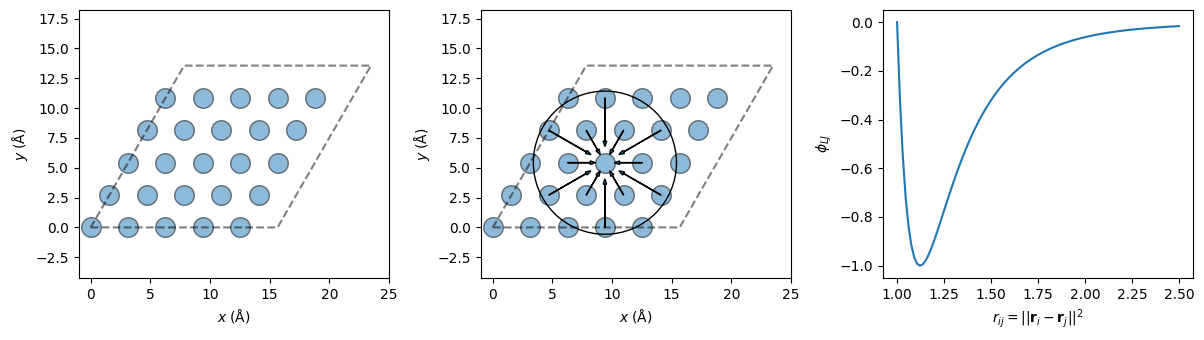

In [4]:
def draw_cell(atoms, ax):
    """Draw cell oriented along [0 0 1] direction."""
    corners = np.stack([
        (atoms.get_scaled_positions()[0] + offset @ atoms.cell.array)[:2]
        for offset in [[0,0,0], [1,0,0], [1, 1, 0], [0,1,0], [0,0,0]]
    ])
    ax.plot(corners[:,0], corners[:,1], linestyle="--", color="k", alpha=0.5)
    ax.set_xlabel(r"$x\;(\mathrm{\AA})$")
    ax.set_ylabel(r"$y\;(\mathrm{\AA})$");
    return

fig, axes = plt.subplots(ncols=3, figsize=(12,3.5))

for ax in axes[:2]:
    ax.scatter(r1, r2, s=200, edgecolors="k", alpha=0.5)
    draw_cell(slab, ax)

    ax.axis("equal")
    ax.set(xlim=(-1, 25), ylim=(-1, 15))


i = 12

fcut = plt.Circle((r1[i], r2[i]), 6, edgecolor="k", facecolor="none")
axes[1].add_patch(fcut)


nbrs = [7, 8, 11, 13, 16, 17]
nbrs += [3, 6, 9, 15, 18, 21]
f = 0.75
for nbr in nbrs:
    ax.arrow(
        r1[nbr], r2[nbr], f*(r1[i]-r1[nbr]), f*(r2[i]-r2[nbr]), 
        width=0.025, head_width=0.3, length_includes_head=True
    )

ax = axes[-1]
rs = np.linspace(1, 2.5, 100)
ax.plot(rs, lj(rs))
ax.set(xlabel=r"$r_{ij} = ||\mathbf{r}_i - \mathbf{r}_j||^2$", ylabel=r"$\phi_{LJ}{(r)$")


plt.tight_layout()

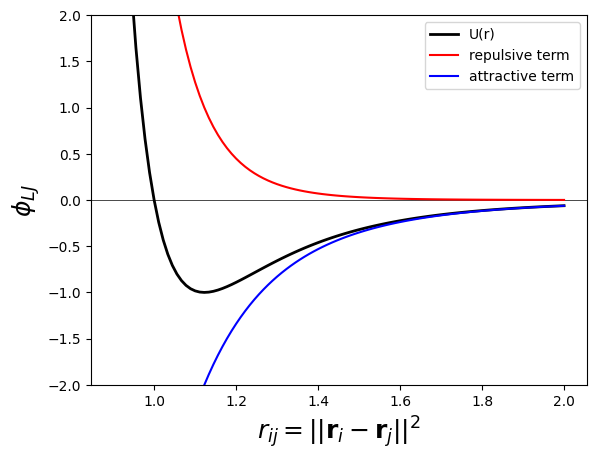

In [25]:
fig, ax = plt.subplots()

def lj(r, sigma=1.0, epsilon=1.0, total=True):
    """Lennard Jones pair interaction."""
    c6 = (sigma / r) ** 6
    c12 = c6 ** 2
    if total: 
        return 4 * epsilon * (c12 - c6)
    else:
        return 4 * epsilon * c12, -4 * epsilon * c6

rs = np.linspace(0.9, 2.0, 100)
ax.axhline(0, color="k", linewidth=0.5)
ax.plot(rs, lj(rs), color="k", label="U(r)", linewidth=2)

Ur, Ua = lj(rs, total=False)
ax.plot(rs, Ur, color="r", label="repulsive term")
ax.plot(rs, Ua, color="b", label="attractive term")

ax.set_ylim(-2, 2)


# ax.set(xlabel=r"$r_{ij} = ||\mathbf{r}_i - \mathbf{r}_j||^2$", ylabel=r"$\phi_{LJ}{(r)$", xlabelsize=16);
ax.set_xlabel(r"$r_{ij} = ||\mathbf{r}_i - \mathbf{r}_j||^2$", size=18)
ax.set_ylabel(r"$\phi_{LJ}{(r)$", size=18);
plt.legend()


Implementing Lennard Jones in pytorch/dgl is straightforward, and it will give us a nice first look at graph computation.
We'll ignore the complication of periodic boundary conditions for now, so we can use the dgl builtin [radius_graph](https://docs.dgl.ai/generated/dgl.radius_graph.html?highlight=radius#dgl.radius_graph) to construct the interaction neighborlist:

In [684]:
import dgl
import dgl.function as fn

cutoff = 4
r = torch.from_numpy(slab.get_positions())
r.requires_grad_(True)
g = dgl.radius_graph(r, cutoff)

In dgl, [graphs](https://docs.dgl.ai/api/python/dgl.DGLGraph.html) have a `dict`-like interface for storing node and edge attributes (`DGLGraph.ndata` and `DGLGraph.edata`), so we can store the atomic positions $\mathbf{r}_{i}$ as node attributes:

In [685]:
# node feature: atomic positions
g.ndata["r"] = r

dgl provides a [message-passing](https://docs.dgl.ai/guide/message.html) interface for expressing graph-based computation.
We can express the Lennard Jones potential with a `message` function `lj_kernel` that computes the bond length and then the pair potential, returning a dictionary of new edge attributes.

In [686]:
def lj_kernel(edges):
    """compute relative position vector -> bond length"""
    r_ij = (edges.dst["r"] - edges.src["r"]).norm(dim=1)
    return {"phi_ij": lj(r_ij)}

`DGLGraph.update_all` applies our pair potential message function to each bond, followed by a `sum` reduction that yields per-atom energy contributions that we can sum  to obtain the total energy of the configuration:

In [687]:
g.update_all(lj_kernel, fn.sum("phi_ij", "energy_i"))
g.ndata["energy_i"]

/Users/bld/.pyenv/versions/3.10.9/envs/nfflr/lib/python3.10/site-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


tensor([-0.0085, -0.0169, -0.0169, -0.0169, -0.0127, -0.0169, -0.0254, -0.0254,
        -0.0254, -0.0169, -0.0169, -0.0254, -0.0254, -0.0254, -0.0169, -0.0169,
        -0.0254, -0.0254, -0.0254, -0.0169, -0.0127, -0.0169, -0.0169, -0.0169,
        -0.0085], grad_fn=<GSpMMBackward>)

In a conventional molecular dynamics code, this would be implemented with `for` loops over a neighbor list. In DGL, it's implemented with sparse matrix multiplication and PyTorch tensor broadcasting.

Advantages:

- simplicity of implementation (no C++ / CUDA in user code)
- portable code (CPU/GPU) with reasonably good performance
- automatic differentiation!

Disadvantages:
- higher memory cost
- slower than LAMMPS (for now?)

We can compute the atomic forces $-\frac{\partial U}{\partial\mathbf{r}_i}$ using the pytorch autograd system, as long as we take care to ensure that the atomic positions $\{\mathbf{r}_i\}$ are included in the autograd graph before executing the model:

In [391]:
from torch.autograd import grad
dU_dr, = grad(g.ndata["energy_i"].sum(), r)
forces = -dU_dr
forces[:5]

tensor([[ 2.4277e-02,  1.4016e-02, -0.0000e+00],
        [ 1.7347e-18,  2.8032e-02, -0.0000e+00],
        [-2.0817e-17,  2.8032e-02, -0.0000e+00],
        [ 4.1633e-17,  2.8032e-02, -0.0000e+00],
        [-1.6185e-02,  2.8032e-02, -0.0000e+00]], dtype=torch.float64)

## multicomponent systems
Multicomponent potentials typically have explicit cross-species parameters.
For example, a Lennard Jones style potential for a binary mixture of Ne and Ar could have three sets of $\sigma$ and $\epsilon$ parameters:


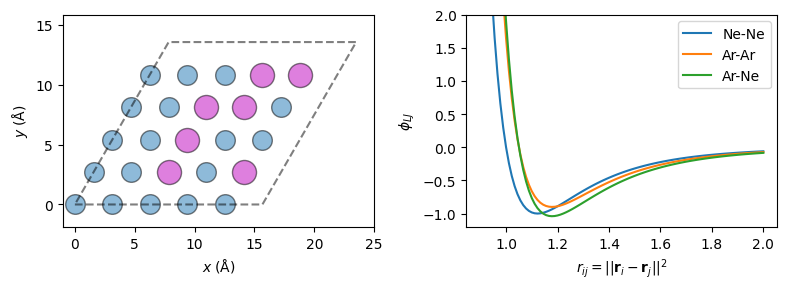

In [28]:
# we'll use fake indices instead of atomic numbers to simplify storing model parameters...
z = np.random.choice([0, 1], len(slab), p=[0.7, 0.3])
slab.set_atomic_numbers(z)

fig, axes = plt.subplots(ncols=2, figsize=(8,3))
ax = axes[0]
ax.scatter(r1[z == 0], r2[z == 0], s=200, edgecolors="k", alpha=0.5)
ax.scatter(r1[z != 0], r2[z != 0], s=300, edgecolors="k", alpha=0.5, color="m")
draw_cell(slab, ax)

ax.axis("equal")
ax.set(xlim=(-1, 25), ylim=(-1, 15));

ax = axes[1]
rs = np.linspace(.9, 2.0, 100)
ax.plot(rs, lj(rs), label="Ne-Ne")
ax.plot(rs, lj(rs, sigma=1.05, epsilon=0.9), label="Ar-Ar")
ax.plot(rs, lj(rs, sigma=1.05, epsilon=1.04), label="Ar-Ne")
ax.set(xlabel=r"$r_{ij} = ||\mathbf{r}_i - \mathbf{r}_j||^2$", ylabel=r"$\phi_{LJ}{(r)$")
ax.set_ylim(-1.2, 2)
plt.legend();
plt.tight_layout()

We could implement this model by adding the atomic numbers as additional edge attributes and modifying our Lennard Jones edge message to look up the parameters for each bond type.

In this case, the pair potential function will be something like $\phi_2(\mathbf{r}_i, \mathbf{r}_j, h_i, h_j)$

In [690]:
r = torch.from_numpy(slab.get_positions())
r.requires_grad_(True)
g = dgl.radius_graph(r, cutoff)

g.ndata["r"] = r
g.ndata["z"] = torch.from_numpy(slab.get_atomic_numbers())
g

Graph(num_nodes=25, num_edges=112,
      ndata_schemes={'r': Scheme(shape=(3,), dtype=torch.float64), 'z': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={})

And our multicomponent message function would look something like:

In [691]:
from torch import nn

sigmas = [1.0, 1.05, 1.05]
epsilons = [1.0, 0.9, 1.04]

sigma = nn.Embedding(3, 1, _weight=torch.tensor(sigmas).unsqueeze(1), _freeze=True)
epsilon = nn.Embedding(3, 1, _weight=torch.tensor(epsilons).unsqueeze(1), _freeze=True)

In [692]:
def bondtype(edges):
    """Look up bond type in binary system."""
    # dst atom types either match src or they are different
    return torch.where(
        edges.src["z"] == edges.dst["z"],
        edges.src["z"],
        2 * torch.ones_like(edges.src["z"])
    )

def binary_lj_kernel(edges):
    """Multicomponent lennard jones interaction."""

    # compute relative position vector -> bond length
    r_ij = (edges.dst["r"] - edges.src["r"]).norm(dim=1)

    # load parameters based on bond type
    b = bondtype(edges)
    sigma_ij = sigma(b).squeeze()
    epsilon_ij = epsilon(b).squeeze()

    # compute speciated pair interaction
    phi_ij = lj(r_ij, sigma=sigma_ij, epsilon=epsilon_ij)

    return {"phi_ij": phi_ij}

In [693]:
g.update_all(binary_lj_kernel, fn.sum("phi_ij", "energy_i"))
g.ndata["energy_i"]

tensor([-0.0110, -0.0220, -0.0220, -0.0202, -0.0127, -0.0202, -0.0320, -0.0338,
        -0.0287, -0.0186, -0.0186, -0.0346, -0.0304, -0.0346, -0.0219, -0.0186,
        -0.0270, -0.0287, -0.0338, -0.0228, -0.0127, -0.0169, -0.0186, -0.0202,
        -0.0101], grad_fn=<GSpMMBackward>)

## GNN potentials (or, who needs cross-terms anyway?)
The essence of GNN potentials is very similar to this model:
- replace the polynomial two-body contributions $\phi_2$ with a simple neural network
- use multiple rounds of pairwise interaction!

that's the entire core idea.

GNN variants primarily differ in the form of the neural networks used, the basis functions used to represent atom and bond lengths, and the reduction function.
Some models also incorporate higher-order interactions, which we'll look at later in the context of the Embedded Atom model and the Tersoff moodel.

### atom input representations
We have already seen this concept hiding in the parameterization of the binary Lennard Jones model.
If we drop the cross-interaction term and collect the Lennard Jones parameters into a single lookup table, we get a matrix of "atom features" $\mathbf{h}_i$

In our Lennard Jones example, $\mathbf{h}_i = [\sigma_i, \epsilon_i]$

In [694]:
sigmas = [1.0, 1.05] # , 1.05]
epsilons = [1.0, 0.9] #, 1.04]

# collect atom features (LJ parameters) in a single parameter matrix
H = torch.tensor([sigmas, epsilons])
H

tensor([[1.0000, 1.0500],
        [1.0000, 0.9000]])

In general, people like to use tabulated physical properties (covalent radii, electronegativities, row, period, atomic number/mass) - or they learn arbitrary "atom embedding"s from whole cloth (analogous to learnable token embeddings in LLMs)

Aside: if we stack global average, range, min, max, and standard deviation reductions without any pair interactions, we get Magpie-style composition features!


### Replacing LJ polynomials with neural networks

#### what is a neural network anyway?

Neural networks have an air of mystique, but it's all just function composition with simple building blocks.

The classic feedforward neural network is:

$$\hat{y} = \mathbf{W}_2 \sigma\left(\mathbf{W}_1 \mathbf{h}^0 \right)$$

$\mathbf{h}^0$ is the input, $\mathbf{W}_1$ and $\mathbf{W}_2$ parameter matrices for linear functions, and $\sigma$ is a pointwise nonlinearity $\sigma(x)  = \frac{1}{1 + e^{-x}}$


In [695]:
# input for atom type 0
h_0 = H[0]

print(f"{h_0=}")

h_0=tensor([1.0000, 1.0500])


In [696]:
# parameter matrix for first linear projection
W_1 = torch.nn.Linear(2, 3, bias=False)
print(f"{W_1.weight=}")

W_1.weight=Parameter containing:
tensor([[-0.6583,  0.6984],
        [ 0.3116,  0.0144],
        [-0.4561,  0.6710]], requires_grad=True)


In [697]:
W_1.weight @ h_0

tensor([0.0750, 0.3268, 0.2484], grad_fn=<MvBackward0>)

The inner linear function projects the input features $\mathbf{h}^0$ into a higher-dimensional intermediate representation $\mathbf{h}^1$ - note the nonlinearity:


$$\mathbf{h}^1 = \sigma\left(\mathbf{W}_1 \mathbf{h}^0\right)$$

Note: modern deep learning models typically use $relu(x) = max(0, x)$ activations. In atomistic modeling, *swish*/SiLU activations $silu(x) = x \sigma(x)$ are more common because its derivative(s) are continuous everywhere.

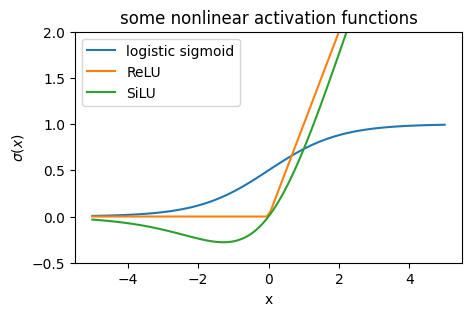

In [340]:
fig, ax = plt.subplots(figsize=(5,3))
xs = torch.linspace(-5, 5, 100)
plt.plot(xs, torch.sigmoid(xs), label="logistic sigmoid")
plt.plot(xs, torch.nn.functional.relu(xs), label="ReLU")
plt.plot(xs, torch.nn.functional.silu(xs), label="SiLU")
plt.xlabel("x")
plt.ylabel(r"$\sigma(x)$");
plt.ylim(-0.5, 2)
plt.legend(loc="upper left");
plt.title("some nonlinear activation functions");

In [698]:
print(f"{h_0=}")

h_1 = torch.sigmoid(W_1.weight @ h_0)

print(f"{h_1=}")

h_0=tensor([1.0000, 1.0500])
h_1=tensor([0.5187, 0.5810, 0.5618], grad_fn=<SigmoidBackward0>)


The outer linear function maps the intermediate $\mathbf{h}^1$ to a scalar prediction $\hat{y}$:

$$\hat{y} = \mathbf{W}_2 \mathbf{h}^1$$

In [699]:
W_2 = torch.nn.Linear(3, 1, bias=False)
print(f"{W_2.weight=}")

W_2.weight=Parameter containing:
tensor([[-0.1466, -0.2429,  0.0226]], requires_grad=True)


In [700]:
W_2.weight @ h_1

tensor([-0.2045], grad_fn=<MvBackward0>)

The full FFN model $\mathbf{W}_2 \sigma\left(\mathbf{W}_1 \mathbf{h}^0 \right)$ just chains the component functions together. The whole model is just matrix-vector multiplication (linear projections) and pointwise nonlinearity functions:

In [701]:
W_2(torch.sigmoid(W_1(h_0)))

tensor([-0.2045], grad_fn=<SqueezeBackward4>)

PyTorch has some nice tools (like `torch.nn.Sequential`) for constructing and working with these composite functions, and for building higher-level modeling abstractions out of basic building blocks:

In [702]:
feedforwardnet = torch.nn.Sequential(
    W_1,
    torch.nn.Sigmoid(),
    W_2
)

feedforwardnet(h_0)

tensor([-0.2045], grad_fn=<SqueezeBackward4>)

The model capacity is controlled by the *depth* of the model (the number of intermediate transformations) and the *width* of the model (the dimensionality of the inputs/intermediate representations)

$$
\begin{align}
\mathbf{W}_1 &\in \mathbb{R}^{(d_{model}, d_{input})} \\
\mathbf{W}_2 &\in \mathbb{R}^{(d_{model}, d_{model})} \\
\mathbf{W}_3 &\in \mathbb{R}^{(d_{output}, d_{model})} \\
\hat{y} &=  \mathbf{W}_3 \sigma \left(\mathbf{W}_2 \sigma\left(\mathbf{W}_1 \mathbf{h}^0 \right) \right) \\
\end{align}
$$

*Aside*: model scaling, generalization, deep double descent...

#### graph convolution
A simple "graph convolution" update combines a single-layer neural network with a feature aggregation over the local atom neighborhoods.

$$\mathbf{h}^{l+1}_i = \sum_{j \in \mathcal{N}(i)} \phi_{ffn} \left( [ \mathbf{h}^l_i ; \mathbf{h}^l_j ; b(\mathbf{r}_j - \mathbf{r}_i) ] \right)$$

where $b$ is a basis function expansion used for the interatomic distances.

As advertised, note how similar the computation is to the Lennard Jones model!

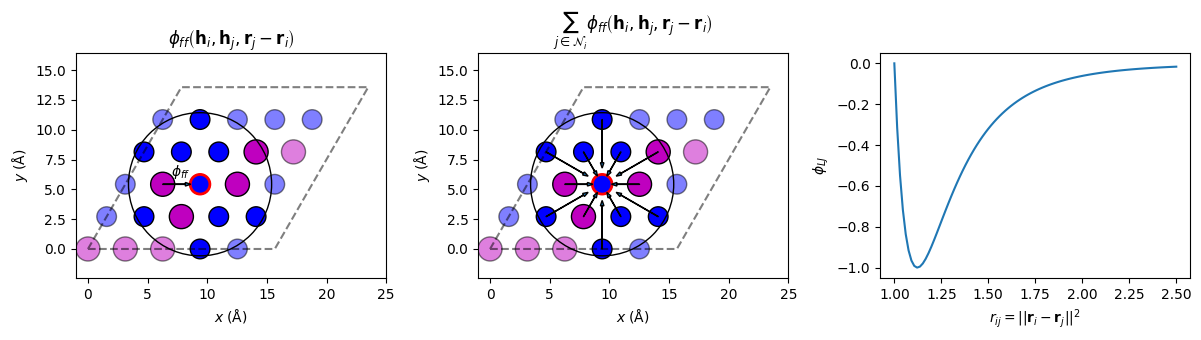

In [703]:
fig, axes = plt.subplots(ncols=3, figsize=(12,3.5))

i = 12
nbrs = [7, 8, 11, 13, 16, 17]
nbrs += [3, 6, 9, 15, 18, 21]

color = np.array(["b", "m"])[(z == 1).astype(int)]
size = np.array([200, 300])[(z == 1).astype(int)]

alpha = 0.5 * np.ones(len(x))
alpha[nbrs] = 1
alpha[i] = 1

# alpha = np.arange(len(x)).in(nbrs)

for ax in axes[:2]:
    ax.scatter(r1, r2, s=size, edgecolors="k", alpha=alpha, color=color)
    ax.scatter(r1[i], r2[i], s=200, edgecolors="r", color="none", linewidth=2)
    fcut = plt.Circle((r1[i], r2[i]), 6, edgecolor="k", facecolor="none")
    ax.add_patch(fcut)

    draw_cell(slab, ax)

    ax.axis("equal")
    ax.set(xlim=(-1, 25), ylim=(-1, 15))

f = 0.75
ax = axes[0]
ax.arrow(
    r1[i-1], r2[i-1], f*(r1[i]-r1[i-1]), f*(r2[i]-r2[i-1]), 
    width=0.025, head_width=0.3, length_includes_head=True
)
ax.annotate(r"$\phi_{ff}$", xy=(r1[i-1]+0.7, r2[i-1]+0.7))
ax.set_title(r"$\phi_{ff}\left(\mathbf{h}_i, \mathbf{h}_j, \mathbf{r}_j - \mathbf{r}_i\right)})$")


ax = axes[1]
ax.set_title(r"$\sum_{j \in \mathcal{N}_i} \phi_{ff}\left( \mathbf{h}_i, \mathbf{h}_j, \mathbf{r}_j - \mathbf{r}_i \right) })$")


for nbr in nbrs:
    ax.arrow(
        r1[nbr], r2[nbr], f*(r1[i]-r1[nbr]), f*(r2[i]-r2[nbr]), 
        width=0.025, head_width=0.3, length_includes_head=True
    )

ax = axes[-1]
rs = np.linspace(1, 2.5, 100)
ax.plot(rs, lj(rs))
ax.set(xlabel=r"$r_{ij} = ||\mathbf{r}_i - \mathbf{r}_j||^2$", ylabel=r"$\phi_{LJ}{(r)$")


plt.tight_layout()

#### unpacking things: basis functions

For example, Gaussian radial basis functions

$$b_k(\mathbf{r}_j - \mathbf{r}_i) = b(r) = \exp \left( \frac{-(r - c_k)^2}{\sigma} \right) $$


where $\mathbf{c}$ is a vector of basis function centers and $\sigma$ is a characteristic length scale hyperparameter.


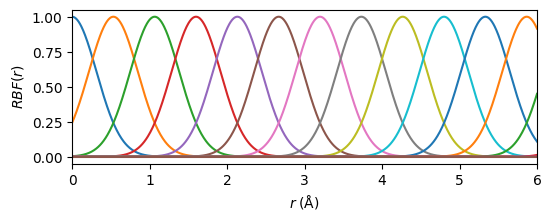

In [42]:
fig, ax = plt.subplots(figsize=(6,2))
xs = torch.linspace(0, 6, 1000)
centers = torch.linspace(0, 8, 16)

def rbf(xs, centers=centers):
    return torch.exp(-(xs[:,None] - centers)**2 / 0.2)

plt.plot(xs, rbf(xs))
plt.xlim(0,6)
plt.xlabel(r"$r \; (\mathrm{\AA})$")
plt.ylabel(r"$RBF(r)$");

(0.0, 6.0)

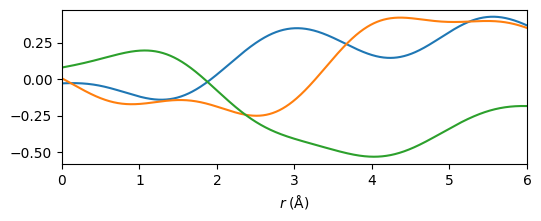

In [43]:
fig, ax = plt.subplots(figsize=(6,2))
xs = torch.linspace(0, 6, 1000)
centers = torch.linspace(0, 8, 16)

def rbf(xs, centers=centers):
    return torch.exp(-(xs[:,None] - centers)**2 / 0.9)

W = torch.nn.Linear(16, 3)

with torch.no_grad():
    plt.plot(xs, W(rbf(xs)))

plt.xlabel(r"$r \; (\mathrm{\AA})$")
plt.xlim(0, 6)

(0.0, 6.0)

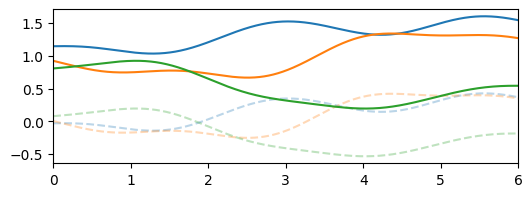

In [49]:
fig, ax = plt.subplots(figsize=(6,2))

with torch.no_grad():
    plt.plot(xs, W(rbf(xs)), alpha=0.3, linestyle="--")

plt.gca().set_prop_cycle(None)
b = torch.randn(3)
with torch.no_grad():
    plt.plot(xs, W(rbf(xs)) + b)

plt.xlim(0, 6)

#### Feedforward model:
 and $\phi_{ffn}$ is a feedforward neural network that operates on concatenated atom and bond features:


In [707]:
r = torch.from_numpy(slab.get_positions())
r.requires_grad_(True)
g = dgl.radius_graph(r, cutoff)

g.ndata["r"] = r
g.ndata["z"] = torch.from_numpy(slab.get_atomic_numbers())

g

Graph(num_nodes=25, num_edges=112,
      ndata_schemes={'r': Scheme(shape=(3,), dtype=torch.float64), 'z': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={})

In [708]:
g.ndata["h"] = H[g.ndata["z"]]

In [709]:
g.ndata["h"][:5]

tensor([[1.0000, 0.9000],
        [1.0000, 0.9000],
        [1.0000, 0.9000],
        [1.0000, 1.0500],
        [1.0000, 1.0500]])

In [469]:
W_gcn = torch.nn.Linear(2 * 2 + centers.size()[0], 8)
W_gcn

Linear(in_features=20, out_features=8, bias=True)

In [711]:
def basic_graphconv_kernel(edges):
    """Simple graph convolution message function."""

    # compute relative position vector -> bond length
    r_ij = (edges.dst["r"] - edges.src["r"]).norm(dim=1)

    # apply rbf expansion
    h_ij = rbf(r_ij)

    # features for atom i and neighbors {j}:
    h_i = edges.src["h"]
    h_j = edges.dst["h"]

    # concatenate atom and bond features
    h_ij = torch.hstack((h_i, h_j, h_ij))

    # compute phi_ffn(h_ij) = W @ h_ij
    h_ij = W_gcn(h_ij)
    h_ij = torch.nn.functional.silu(h_ij)

    return {"h_ij": h_ij}

In [712]:
g.update_all(basic_graphconv_kernel, fn.sum("h_ij", "h"))
g.ndata["h"]

/Users/bld/.pyenv/versions/3.10.9/envs/nfflr/lib/python3.10/site-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


tensor([[ 0.2538,  0.0829,  0.3012,  0.4045,  0.1520, -0.0953, -0.0407, -0.2622],
        [ 0.5076,  0.1658,  0.6023,  0.8090,  0.3039, -0.1906, -0.0814, -0.5244],
        [ 0.5076,  0.1658,  0.6023,  0.8090,  0.3039, -0.1906, -0.0814, -0.5244],
        [ 0.5739,  0.1288,  0.6598,  0.8589,  0.3046, -0.1950, -0.0214, -0.5230],
        [ 0.4403,  0.1011,  0.5022,  0.6777,  0.2546, -0.1544, -0.0159, -0.3937],
        [ 0.5739,  0.1288,  0.6598,  0.8589,  0.3046, -0.1950, -0.0214, -0.5230],
        [ 0.8543,  0.1901,  0.9849,  1.2659,  0.4394, -0.2870, -0.0322, -0.7837],
        [ 0.7678,  0.2517,  0.9083,  1.2356,  0.4733, -0.2913, -0.1220, -0.7876],
        [ 0.8674,  0.1962,  0.9946,  1.3107,  0.4743, -0.2979, -0.0320, -0.7855],
        [ 0.5805,  0.1318,  0.6647,  0.8813,  0.3220, -0.2004, -0.0213, -0.5240],
        [ 0.5805,  0.1318,  0.6647,  0.8813,  0.3220, -0.2004, -0.0213, -0.5240],
        [ 0.7742,  0.2548,  0.9130,  1.2577,  0.4908, -0.2968, -0.1219, -0.7885],
        [ 0.8608

In [713]:
# encapsulate this in a torch.nn.Module
class SimpleGraphConv(torch.nn.Module):
    def __init__(self, in_features=2, edge_features=16, out_features=8):
        super().__init__()
        d_input = 2 * in_features + edge_features
        self.linear = torch.nn.Linear(d_input, out_features)

    def graphconv_kernel(self, edges):
        """Simple graph convolution message function."""

        # apply edge basis functions and concatenate features
        h_ij = torch.hstack((edges.src["h"], edges.dst["h"], edges.data["h"]))

        # compute phi_ffn(h_ij) = W @ h_ij
        h_ij = self.linear(h_ij)
        h_ij = torch.nn.functional.silu(h_ij)

        return {"h_ij": h_ij}

    def forward(self, g: dgl.DGLGraph, h: torch.Tensor):
        g.ndata["h"] = h
        g.update_all(self.graphconv_kernel, fn.sum("h_ij", "h"))
        return g.ndata.pop("h")

f_gcn = SimpleGraphConv()

g = dgl.radius_graph(r, cutoff)
g.ndata["r"] = r
g.ndata["z"] = torch.from_numpy(slab.get_atomic_numbers())
g.ndata["h"] = H[g.ndata["z"]]

# compute relative position vectors
g.apply_edges(fn.v_sub_u("r", "r", "r"))

# expand bond length basis functions
g.edata["h"] = rbf(g.edata["r"].norm(dim=1))

f_gcn(g, g.ndata["h"])

tensor([[-3.4050e-01, -4.4973e-03, -2.6951e-01,  1.0237e+00, -5.3831e-02,
         -1.4995e-01,  2.1809e-01,  2.1819e-02],
        [-6.8100e-01, -8.9947e-03, -5.3903e-01,  2.0475e+00, -1.0766e-01,
         -2.9990e-01,  4.3619e-01,  4.3638e-02],
        [-6.8100e-01, -8.9947e-03, -5.3903e-01,  2.0475e+00, -1.0766e-01,
         -2.9990e-01,  4.3619e-01,  4.3638e-02],
        [-7.1539e-01,  5.9684e-03, -5.8091e-01,  2.1371e+00, -1.1306e-01,
         -2.7036e-01,  4.3500e-01,  3.2003e-02],
        [-5.4256e-01, -8.3074e-03, -4.3533e-01,  1.6286e+00, -9.9828e-02,
         -2.2080e-01,  3.3761e-01,  4.0443e-02],
        [-7.1539e-01,  5.9684e-03, -5.8091e-01,  2.1371e+00, -1.1306e-01,
         -2.7036e-01,  4.3500e-01,  3.2003e-02],
        [-1.0691e+00,  1.7475e-02, -8.7160e-01,  3.1885e+00, -1.5957e-01,
         -3.9352e-01,  6.4492e-01,  3.7044e-02],
        [-1.0257e+00, -2.1951e-02, -8.0830e-01,  3.0882e+00, -1.7154e-01,
         -4.6163e-01,  6.6186e-01,  7.6478e-02],
        [-1.0771

In [714]:
# stack multiple modules

class SimpleGraphConvNet(torch.nn.Module):
    def __init__(self, in_features=2, edge_features=16, d_model=8, out_features=1):
        super().__init__()

        self.gcn_layers = torch.nn.ModuleList(
            [
                SimpleGraphConv(in_features, edge_features, d_model),
                SimpleGraphConv(d_model, edge_features, d_model),
                SimpleGraphConv(d_model, edge_features, out_features)
            ]
        )

    def forward(self, g: dgl.DGLGraph):
        
        h = g.ndata.pop("h")

        for layer in self.gcn_layers:
            h = layer(g, h)

        # global sum pooling
        output = h.sum()

        return output

In [715]:
gcn_model = SimpleGraphConvNet(in_features=2, edge_features=16, d_model=32, out_features=1)

g = dgl.radius_graph(r, cutoff)
g.ndata["r"] = r
g.ndata["z"] = torch.from_numpy(slab.get_atomic_numbers())
g.ndata["h"] = H[g.ndata["z"]]

# compute relative position vectors
g.apply_edges(fn.v_sub_u("r", "r", "r"))

# expand bond length basis functions
g.edata["h"] = rbf(g.edata["r"].norm(dim=1))

gcn_model(g)

tensor(33.1274, grad_fn=<SumBackward0>)

# Three-body interactions: Tersoff potential

For some materials (especially with covalent bonding, e.g. Si and other semiconductors), explicit bond angle terms are required for reasonable performance of empirical potentials

For example, the Tersoff model (Tersoff, 1988, [10.1103/PhysRevB.38.9902](https://dx.doi.org/10.1103/PhysRevB.38.9902))

We'll follow the [LAMMPS implementation](https://docs.lammps.org/pair_tersoff.html#description), but we'll omit the cutoff functions here for clarity:

$$
\begin{align}
U_{ij} &= \phi_r(r_{ij}) + b_{ij} \phi_a(r_{ij}) \\
\phi_r(r) &= A \exp(-\lambda_1 r) \\
\phi_a(r) &= -B \exp(-\lambda_2 r) \\
\end{align}
$$

So Tersoff is just a pair of exponential repulsive and attractive terms $\phi_r$ and $\phi_a$, with a term $b_{ij}$ that models the *importance* of the attractive term.

($A$, $B$, $\lambda_1$, and $\lambda_2$ are some of the empirical parameters of the potential)

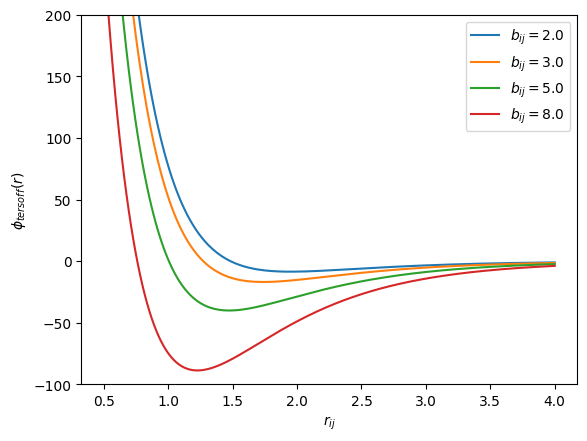

In [665]:
# plot cartoon Tersoff Si potential
rs = np.linspace(0.5, 4, 200)
A=3264.7
lambda1 = 3.2394
B = 95.373
lambda2 = 1.3258 

b_ij = 5.0

for b_ij in [2.0, 3.0, 5.0, 8.0]:
    plt.plot(rs, A * np.exp(-lambda1 * rs) -b_ij * B * np.exp(-lambda2 * rs), label=f"$b_{{ij}}={b_ij}$")

plt.legend();
plt.xlabel("$r_{ij}$")
plt.ylabel("$\phi_{tersoff}(r)$");
plt.ylim(-100, 200);

$b_{ij}$ is a *three-body* term that accounts for the angles between bonds

$$
\begin{align}
b_{ij} &= (1 + \beta^n \zeta_{ij}^n)^{-\frac{1}{2n}} \\
\zeta_{ij} &= \sum_{k\neq i, j} g\left(\theta_{kij}(\mathbf{r}_{ij}, \mathbf{r}_{ik})\right) \\
g(\theta) &= \gamma_{kij} \left( 1 + \frac{c^2}{d^2} - \frac{c^2}{d^2 + (cos(\theta) - cos(\theta_0))^2} \right)

\end{align}
$$

$\beta$, $n$, $m$, $\gamma_{kij}$, $c$, $d$, $\theta_0$ are additional empirical parameters.

So Tersoff first looks at all triplets of atoms to compute the bond weights $b_{ij}$, and then computes the pair potential like before:

In [716]:
def tersoff_g(theta, gamma=1.0, c=4.8381, d = 2.0417, costheta_0 = 0.0):    
    return gamma * (1 + (c**2 / d**2) + c**2 / (d**2 + (torch.cos(theta) - costheta_0)**2 ))

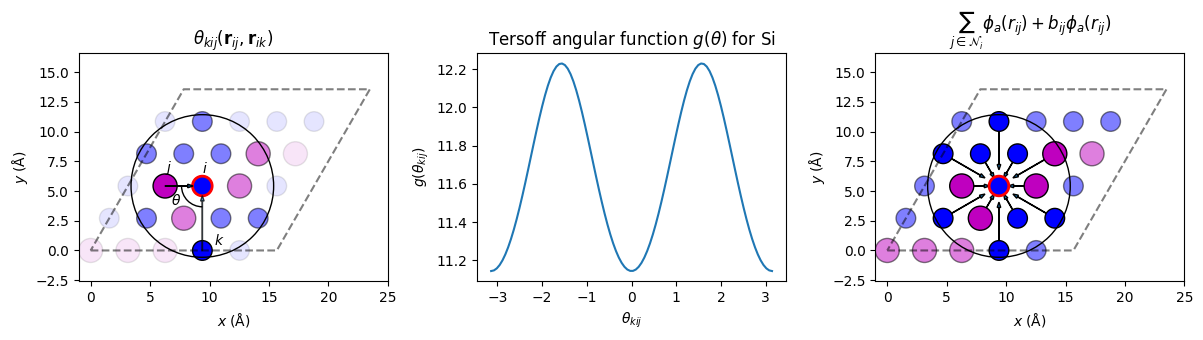

In [717]:
import matplotlib
fig, axes = plt.subplots(ncols=3, figsize=(12,3.5))

i = 12
k = 3 # 7
nbrs = [7, 8, 11, 13, 16, 17]
nbrs += [3, 6, 9, 15, 18, 21]

color = np.array(["b", "m"])[(z == 1).astype(int)]
size = np.array([200, 300])[(z == 1).astype(int)]

# alpha = 0.5 * np.ones(len(x))
# alpha[nbrs] = 1
# alpha[i] = 1

alpha = 0.1 * np.ones(len(x))
alpha[nbrs] = 0.5
alpha[i-1] = 1
alpha[i] = 1
alpha[k] = 1


ax = axes[0]
ax.scatter(r1, r2, s=size, edgecolors="k", alpha=alpha, color=color)
ax.scatter(r1[i], r2[i], s=200, edgecolors="r", color="none", linewidth=2)
fcut = plt.Circle((r1[i], r2[i]), 6, edgecolor="k", facecolor="none")
ax.add_patch(fcut)

draw_cell(slab, ax)

ax.axis("equal")
ax.set(xlim=(-1, 25), ylim=(-1, 15))

f = 0.75
ax = axes[0]
ax.arrow(
    r1[i-1], r2[i-1], f*(r1[i]-r1[i-1]), f*(r2[i]-r2[i-1]), 
    width=0.025, head_width=0.3, length_includes_head=True
)
# ax.annotate(r"$\phi_{ff}$", xy=(r1[i-1]+0.7, r2[i-1]+0.7))
# ax.set_title(r"$\phi_{ff}\left(\mathbf{h}_i, \mathbf{h}_j, \mathbf{r}_j - \mathbf{r}_i\right)})$")
ax.set_title(r"$\theta_{kij}\left(\mathbf{r}_{ij}, \mathbf{r}_{ik}\right)})$")

ax = axes[1]
# rs = np.linspace(1, 2.5, 100)
# ax.plot(rs, lj(rs))
# ax.set(xlabel=r"$r_{ij} = ||\mathbf{r}_i - \mathbf{r}_j||^2$", ylabel=r"$\phi_{LJ}{(r)$")


thetas = torch.linspace(-np.pi, np.pi, 100)
ax.plot(thetas, tersoff_g(thetas))
ax.set_xlabel(r"$\theta_{kij}$")
ax.set_ylabel(r"$g(\theta_{kij})$");
ax.set_title(r"Tersoff angular function $g(\theta)$ for Si");


ax = axes[0]
ax.annotate(r"$i$", xy=(r1[i], r2[i]+1.1))
ax.annotate(r"$j$", xy=(r1[i-1], r2[i-1]+1.2))
ax.annotate(r"$k$", xy=(r1[k]+1, r2[k]+0.5))
ax.arrow(
    r1[k], r2[k], 0.85*(r1[i]-r1[k]), 0.85*(r2[i]-r2[k]), 
    width=0.025, head_width=0.3, length_includes_head=True, alpha=0.75
)

r_arc = 3.5
arc = matplotlib.patches.Arc((r1[i], r2[i]), r_arc, r_arc, theta1=180.0, theta2=270, edgecolor="k", facecolor="none")
ax.add_patch(arc)
ax.annotate(r"$\theta$", xy=(6.8,3.8))


ax = axes[-1]
ax = axes[-1]
# ax.set_title(r"$\sum_{j \in \mathcal{N}_i} \phi_{ff}\left( \mathbf{h}_i, \mathbf{h}_j, \mathbf{r}_j - \mathbf{r}_i \right) })$")
ax.set_title(r"$\sum_{j \in \mathcal{N}_i} \phi_{a}(r_{ij}) + b_{ij}\phi_a(r_{ij})$")
# \left( \mathbf{h}_i, \mathbf{h}_j, \mathbf{r}_j - \mathbf{r}_i \right) })$")


for nbr in nbrs:
    ax.arrow(
        r1[nbr], r2[nbr], f*(r1[i]-r1[nbr]), f*(r2[i]-r2[nbr]), 
        width=0.025, head_width=0.3, length_includes_head=True
    )


alpha = 0.5 * np.ones(len(x))
alpha[nbrs] = 1
alpha[i] = 1
ax.scatter(r1, r2, s=size, edgecolors="k", alpha=alpha, color=color)
ax.scatter(r1[i], r2[i], s=200, edgecolors="r", color="none", linewidth=2)
fcut = plt.Circle((r1[i], r2[i]), 6, edgecolor="k", facecolor="none")
ax.add_patch(fcut)

draw_cell(slab, ax)

ax.axis("equal")
ax.set(xlim=(-1, 25), ylim=(-1, 15))



plt.tight_layout()

The Tersoff model can be implemented pretty straightforwardly by performing message passing on the [line graph](https://docs.dgl.ai/generated/dgl.line_graph.html#dgl.line_graph) to compute the $b_{ij}$ terms.

The core of this is the computation of $\zeta_{ij}$ (but the full implementation is [here](https://github.com/usnistgov/nfflr/blob/main/nfflr/models/classical/tersoff.py#L126)):

In [671]:
def zeta_message(edges):

    """Zeta_ij kernel for Tersoff potential

    line graph edges: (k -> i) -> (i -> j)

    message propagation updates the (i -> j) bond
    """

    # relative position vectors for src and dst bonds
    # negate src bond relative position to obtain k <- i -> j
    r_ik = -edges.src["r"]
    r_ij = edges.dst["r"]

    # relative position vectors for src and dst bonds
    # negate src bond relative position to obtain k <- i -> j
    r_ik = -edges.src["r"]
    r_ij = edges.dst["r"]

    bondlen_ij = torch.norm(r_ij, dim=1)
    bondlen_ik = torch.norm(r_ik, dim=1)

    bond_cosine = torch.sum(r_ik * r_ij, dim=1) / (bondlen_ik * bondlen_ij)
    bond_cosine = torch.clamp(bond_cosine, -1, 1)

    return {"zeta_kij": tersoff_g(bond_cosine)}

The line graph constructs a new graph from the neighborlist graph, where each node in the line graph corresponds to a bond in the neighborlist graph, and each edge in the line graph corresponds to a bond angle (a triple of atoms).

We keep the bond features $\mathbf{r}_{ij}$ (the relative position vectors) to compute the bond cosines in the three-body update function.

In [673]:
lg = g.line_graph(shared=True, backtracking=False)
lg

Graph(num_nodes=112, num_edges=430,
      ndata_schemes={'r': Scheme(shape=(3,), dtype=torch.float64), 'h': Scheme(shape=(16,), dtype=torch.float64)}
      edata_schemes={})

`apply_edges` computes the angular term for all three-body interactions in the system:

In [678]:
lg.apply_edges(zeta_message)
lg.edata["zeta_kij"]

tensor([11.8629, 11.3548, 11.3548, 11.3548, 11.3548, 11.8629, 11.3548, 11.8629,
        11.3548, 11.3548, 11.3548, 11.3548, 11.3548, 11.3548, 11.3548, 11.3548,
        11.3548, 11.8629, 11.8629, 11.3548, 11.3548, 11.8629, 11.3548, 11.3548,
        11.3548, 11.3548, 11.3548, 11.8629, 11.3548, 11.3548, 11.3548, 11.3548,
        11.3548, 11.8629, 11.8629, 11.3548, 11.3548, 11.3548, 11.3548, 11.3548,
        11.3548, 11.3548, 11.8629, 11.3548, 11.3548, 11.3548, 11.3548, 11.3548,
        11.8629, 11.8629, 11.3548, 11.3548, 11.3548, 11.3548, 11.3548, 11.8629,
        11.3548, 11.3548, 11.3548, 11.8629, 11.3548, 11.3548, 11.3548, 11.3548,
        11.3548, 11.3548, 11.8629, 11.3548, 11.3548, 11.3548, 11.3548, 11.8629,
        11.3548, 11.3548, 11.3548, 11.3548, 11.3548, 11.3548, 11.3548, 11.3548,
        11.3548, 11.3548, 11.3548, 11.8629, 11.3548, 11.3548, 11.3548, 11.3548,
        11.3548, 11.3548, 11.3548, 11.3548, 11.3548, 11.8629, 11.3548, 11.3548,
        11.3548, 11.3548, 11.3548, 11.35

Or, `update_all` with a sum reduction computes the pairwise $\zeta_{ij}$ terms, which we can then use in a pair interaction like we did with the Lennard Jones model:

In [679]:
lg.update_all(zeta_message, fn.sum("zeta_kij", "zeta_ij"))
lg.ndata["zeta_ij"]

/Users/bld/.pyenv/versions/3.10.9/envs/nfflr/lib/python3.10/site-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


tensor([11.3548, 11.3548, 34.5724, 34.5724, 34.0643, 34.0643, 34.5724, 34.5724,
        34.0643, 34.0643, 34.5724, 34.5724, 34.0643, 34.0643, 22.7095, 22.7095,
        22.7095, 34.5724, 34.0643, 34.0643, 34.5724, 57.2820, 57.2820, 57.2820,
        57.2820, 57.2820, 57.2820, 57.2820, 57.2820, 57.2820, 57.2820, 57.2820,
        57.2820, 57.2820, 57.2820, 57.2820, 57.2820, 57.2820, 57.2820, 34.5724,
        34.0643, 34.0643, 34.5724, 34.5724, 34.0643, 34.0643, 34.5724, 57.2820,
        57.2820, 57.2820, 57.2820, 57.2820, 57.2820, 57.2820, 57.2820, 57.2820,
        57.2820, 57.2820, 57.2820, 57.2820, 57.2820, 57.2820, 57.2820, 57.2820,
        57.2820, 34.5724, 34.0643, 34.0643, 34.5724, 34.5724, 34.0643, 34.0643,
        34.5724, 57.2820, 57.2820, 57.2820, 57.2820, 57.2820, 57.2820, 57.2820,
        57.2820, 57.2820, 57.2820, 57.2820, 57.2820, 57.2820, 57.2820, 57.2820,
        57.2820, 57.2820, 57.2820, 34.5724, 34.0643, 34.0643, 34.5724, 22.7095,
        22.7095, 22.7095, 34.0643, 34.06

Wrapping it up: the information flow in this model is quite similar to ALIGNN - the main difference is that we parameterize the three-body interactions with another graph convolution layer that updates the bond features instead of a scalar function.

## Embedded atom model

The Lennard Jones model can reproduce many of the behaviors of ideal gases, but it is not particularly useful for modeling solids.
Let's take a look at the Embedded Atom Method, which is a widely used model for metallic systems.

The energy is decomposed into pairwise $\phi_2$ terms and an embedding function $F(\rho)$ of the electron density $\rho_i$ around each atom $i$.

$$
\begin{align}
U(\{\mathbf{r}\}) &= \sum_i \sum_j \phi_2(r_{ij}) + \sum_i F(\rho_i)\\
\end{align}
$$

The estimate of the local electron densities $\rho_i$ are themselves modeled as a pairwise expansion

$$
\rho_i = \sum_{j \neq i} f(r_{ij})
$$

Typically, the pair potential $\phi_2$, the density function $f$, and the embedding function $F$ are cubic splines.
[Early EAM work](https://dx.doi.org/10.1103/physrevb.33.7983) parameterized the density function $f$ in terms of *ab initio* calculations of the atomic densities, but sometimes more recent EAM style potentials are fully empirical.

In [364]:
!curl https://www.ctcms.nist.gov/potentials/Download/1999--Mishin-Y-Farkas-D-Mehl-M-J-Papaconstantopoulos-D-A--Al/2/Al99.eam.alloy -o Al99.eam.alloy

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  762k  100  762k    0     0  4122k      0 --:--:-- --:--:-- --:--:-- 4187k


In [366]:
from nfflr.models.classical.eam import TorchEAM
eam = TorchEAM("Al99.eam.alloy")

The pair potential term $\phi_2$ can be implemented using the same approach as with the Lennard Jones model.
The local density computation is more interesting because we can use graph message passing to implement it:

In [367]:
slab = fcc111('Au', size=(20,20,1), vacuum=10.0)
slab.rattle(stdev=0.12)
r1, r2, r3 = slab.get_positions().T

r = torch.from_numpy(slab.get_positions())
g = dgl.radius_graph(r, eam.data.cutoff)
g.ndata["r"] = r

g

Graph(num_nodes=400, num_edges=6420,
      ndata_schemes={'r': Scheme(shape=(3,), dtype=torch.float64)}
      edata_schemes={})

First, compute the bond lengths and evaluate the pair potential spline $\phi_2$ and the local density contribution spline $f$:

In [368]:
g.apply_edges(fn.v_sub_u("r", "r", "r_ij"))
bondlength = g.edata["r_ij"].norm(dim=1)

/Users/bld/.pyenv/versions/3.10.9/envs/nfflr/lib/python3.10/site-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In [371]:
bondlength = g.edata["r_ij"].norm(dim=1)
rho_ij, rphi = eam.radial_spline.evaluate(bondlength).split(1, dim=1)

Next, aggregate the local density contributions over neighborhoods to obtain $\rho_i = \sum_{j \neq i} f(r_{ij})$

In [372]:
import dgl.function as fn
g.edata["rho_ij"] = rho_ij
g.update_all(fn.copy_e("rho_ij", "m"), fn.sum("m", "rho"))
rho = g.ndata.pop("rho")

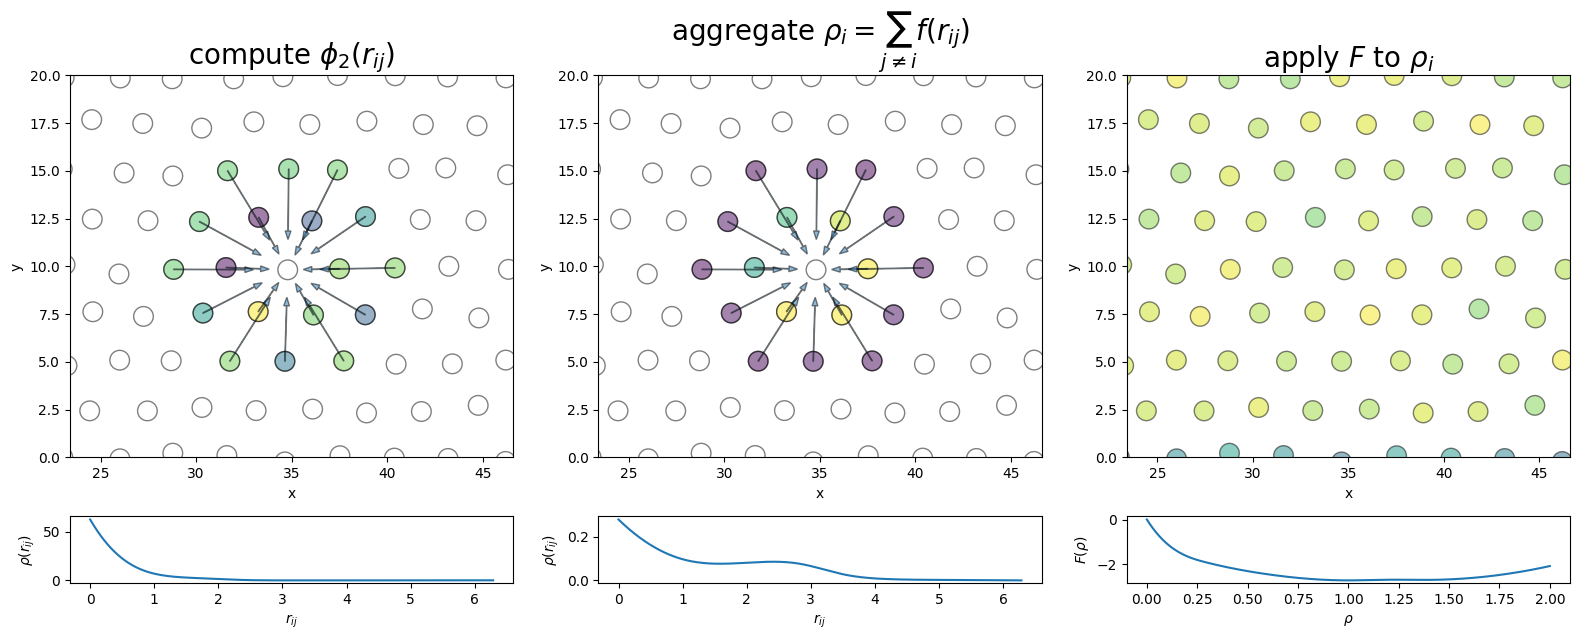

In [373]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(16,6.5))
gs = GridSpec(9, 9, figure=fig)
ax1 = fig.add_subplot(gs[:7,:3])
ax2 = fig.add_subplot(gs[7:,:3])

ax3 = fig.add_subplot(gs[:7,3:6])
ax4 = fig.add_subplot(gs[7:,3:6])

ax5 = fig.add_subplot(gs[:7,6:])
ax6 = fig.add_subplot(gs[7:,6:])

# highlight a specific atom i and its neighborhood
# i = 70
i = 90
src, dst = g.all_edges()
nbrs = dst == i

# plot the pair potential
ax = ax1
ax.scatter(r1, r2, s=200, edgecolors="k", alpha=0.5, color="none")
ax.scatter(r1[src[nbrs]], r2[src[nbrs]], s=200, edgecolors="k", alpha=0.5, c=(rphi.squeeze() / bondlength)[nbrs])
ax.axis("equal")
ax.set(xlabel="x", ylabel="y")
ax.set(xlim=(25, 45), ylim=(0, 20))

f = 0.7
for nbr in src[nbrs]:
    ax.arrow(
        r1[nbr], r2[nbr], f*(r1[i]-r1[nbr]), f*(r2[i]-r2[nbr]), 
        width=0.025, head_width=0.3, length_includes_head=True, alpha=0.5
    )

ax2.plot(eam.data.rs, eam.data.rphi_data / eam.data.rs)
ax2.set(xlabel=r"$r_{ij}$", ylabel=r"$\rho(r_{ij})$")

# plot the local density function
ax = ax3
ax.scatter(r1, r2, s=200, edgecolors="k", alpha=0.5, color="none")
ax.scatter(r1[src[nbrs]], r2[src[nbrs]], s=200, edgecolors="k", alpha=0.5, c=rho_ij[nbrs])
# draw_cell(slab, ax)
ax.axis("equal")
ax.set(xlabel="x", ylabel="y")
ax.set(xlim=(25, 45), ylim=(0, 20))

f = 0.7
for nbr in src[nbrs]:
    ax.arrow(
        r1[nbr], r2[nbr], f*(r1[i]-r1[nbr]), f*(r2[i]-r2[nbr]), 
        width=0.025, head_width=0.3, length_includes_head=True, alpha=0.5
    )

ax4.plot(eam.data.rs, eam.data.density_data)
ax4.set(xlabel=r"$r_{ij}$", ylabel=r"$\rho(r_{ij})$")

# draw the aggregated density \rho
ax = ax5
ax.scatter(r1, r2, s=200, edgecolors="k", alpha=0.5, c=rho)
ax.axis("equal")
ax.set(xlabel="x", ylabel="y")
ax.set(xlim=(25, 45), ylim=(0, 20))

ax6.plot(eam.data.rhos, eam.data.embedded_data)
ax6.set(xlabel=r"$\rho$", ylabel=r"$F(\rho)$")


ax1.set_title(r"compute $\phi_2(r_{ij})$", size=20)
ax3.set_title(r"aggregate $\rho_i = \sum_{j \neq i} f(r_{ij})$", size=20)
ax5.set_title(r"apply $F$ to $\rho_i$", size=20)
plt.tight_layout()


### Aside: Multicomponent EAM
Multicomponent potentials typically have explicit cross-species parameters - for example this quinary AlCrFeCoNi EAM potential has five embedding functions $F_s$, five density functions $\rho_s$, and 15 pair terms $\phi_{2,s}$:

In [376]:
! curl https://www.ctcms.nist.gov/potentials/Download/2020--Farkas-D-Caro-A--Fe-Ni-Cr-Co-Al/1/FeNiCrCoAl-heaweight.setfl -o FeNiCrCoAl-heaweight.setfl

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1791k  100 1791k    0     0  7628k      0 --:--:-- --:--:-- --:--:-- 7688k


In [377]:
import re
from collections import defaultdict
def load_cantor():

    Nrho = 2000
    drho = 0.1000500250125062E-02
    rhos = torch.tensor(drho * np.arange(Nrho))

    Nr = 3000
    dr = 0.1935228409469823E-02
    rs = torch.tensor(dr * np.arange(Nr))

    data = defaultdict(list)
    header = True
    with open("FeNiCrCoAl-heaweight.setfl", "r") as f:
        for line in f:
            if re.search("fcc$", line.strip()):
                header = False
                key = int(line.strip().split()[0])
                continue

            elif header:
                continue
            
            else:
                data[key] += list(map(float, line.strip().split()))

    # last component has all the pair potentials concatenated on
    k = list(data.keys())[-1]
    phi_data = torch.tensor(data[k][Nrho + Nr : ])
    data[k] = data[k][:Nrho + Nr]

    return rs, rhos, data, phi_data, 

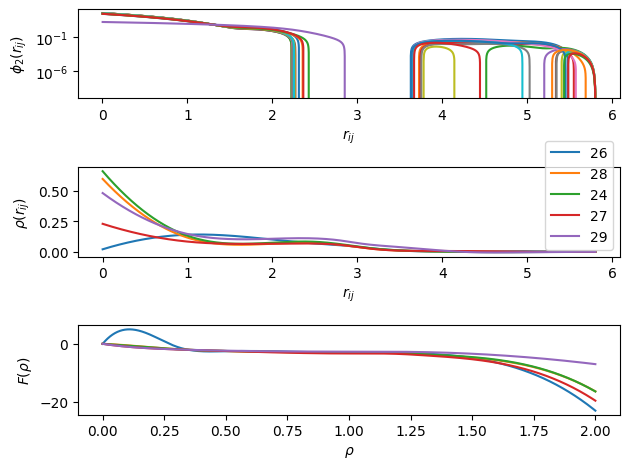

In [378]:
rs, rhos, data, phi_data = load_cantor()

fig, axes = plt.subplots(nrows=3)

for phi in phi_data.split(len(rs)):
    axes[0].plot(rs, phi / rs)

axes[0].set(xlabel=r"$r_{ij}$", ylabel=r"$\phi_2(r_{ij})$")
axes[0].semilogy()

for k, v in data.items():
    axes[1].plot(rs, v[len(rhos):], label=k)
axes[1].set(xlabel=r"$r_{ij}$", ylabel=r"$\rho(r_{ij})$")
axes[1].legend()


for k, v in data.items():
    axes[2].plot(rhos, v[:len(rhos)])
axes[2].set(xlabel=r"$\rho$", ylabel=r"$F(\rho)$")
plt.tight_layout()


## Graph convolution networks

